# Working with HLS datasets: cloud cover, GeoTIFFs, and the QA band

This guide shows how to use some of the utilities implemented in *nasa_hls* for working with NASA's Harmonized Landsat and Sentinel-2 Project (https://hls.gsfc.nasa.gov/) data.
It covers the follwoing topics:

* Derive the cloud cover percentage from the metadata of a HDF file.

* Convert HDF datasets to single layer GeoTIFFs.

* Convert the binary QA layer in a clear-sky mask.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import rasterio

import nasa_hls

## The sample data 

We assume the data that has been created wiht the 'Query and download HLS datasets with *nasa_hls*' guide.

In [2]:
hdf_dir = Path("./xxx_uncontrolled_hls/downloads")
geotiff_dir = Path("./xxx_uncontrolled_hls/geotiffs")

import pandas as pd
df_downloaded = pd.read_csv("./xxx_uncontrolled_hls/downloads/df_downloads.csv", index_col="id")
display(df_downloaded)

,product,tile,date,url,year,month,day,path
id,,,,,,,,
HLS.L30.T32UNU.2018092.v1.4,L30,32UNU,2018-04-02,https://hls.gsfc.nasa.gov/data/v1.4/L30/2018/3...,2018,4,2,./xxx_uncontrolled_hls/downloads/HLS.L30.T32UN...
HLS.S30.T32UNU.2018092.v1.4,S30,32UNU,2018-04-02,https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...,2018,4,2,./xxx_uncontrolled_hls/downloads/HLS.S30.T32UN...
HLS.L30.T32UPU.2018092.v1.4,L30,32UPU,2018-04-02,https://hls.gsfc.nasa.gov/data/v1.4/L30/2018/3...,2018,4,2,./xxx_uncontrolled_hls/downloads/HLS.L30.T32UP...
HLS.S30.T32UPU.2018092.v1.4,S30,32UPU,2018-04-02,https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...,2018,4,2,./xxx_uncontrolled_hls/downloads/HLS.S30.T32UP...
HLS.L30.T32UPU.2018099.v1.4,L30,32UPU,2018-04-09,https://hls.gsfc.nasa.gov/data/v1.4/L30/2018/3...,2018,4,9,./xxx_uncontrolled_hls/downloads/HLS.L30.T32UP...
HLS.S30.T32UPU.2018099.v1.4,S30,32UPU,2018-04-09,https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...,2018,4,9,./xxx_uncontrolled_hls/downloads/HLS.S30.T32UP...
HLS.L30.T32UNU.2018115.v1.4,L30,32UNU,2018-04-25,https://hls.gsfc.nasa.gov/data/v1.4/L30/2018/3...,2018,4,25,./xxx_uncontrolled_hls/downloads/HLS.L30.T32UN...
HLS.S30.T32UNU.2018115.v1.4,S30,32UNU,2018-04-25,https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...,2018,4,25,./xxx_uncontrolled_hls/downloads/HLS.S30.T32UN...


## Derive metadata from HDF file 

The HDF files come with rich metadata that can be read from the files with ``gdalinfo``.
The [HLS v1.4 UserGuide](https://hls.gsfc.nasa.gov/wp-content/uploads/2019/01/HLS.v1.4.UserGuide_draft_ver3.1.pdf) lists the metadata fields with a short description in Section 6.6.

The full outcome of ``gdalinfo`` for the sample scene looks as follows:

In [3]:
%%bash
gdalinfo ./xxx_uncontrolled_hls/geotiffs/HLS.L30.T32UNU.2018092.v1.4/HLS.L30.T32UNU.2018092.v1.4__QA.tif

Driver: GTiff/GeoTIFF
Files: ./xxx_uncontrolled_hls/geotiffs/HLS.L30.T32UNU.2018092.v1.4/HLS.L30.T32UNU.2018092.v1.4__QA.tif
       ./xxx_uncontrolled_hls/geotiffs/HLS.L30.T32UNU.2018092.v1.4/HLS.L30.T32UNU.2018092.v1.4__QA.tif.aux.xml
Size is 3660, 3660
Coordinate System is:
PROJCS["UTM Zone 32, Northern Hemisphere",
    GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",
        DATUM["Not_specified_based_on_WGS_84_spheroid",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",9],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]
Origin = (499980.000000000000000,5400000.000000000000000)
Pixel Size = (30.000000000000000,-30.000000000000000

The values for the fields separated from its values with a '=' derived given a HDF file.

In [4]:
print(df_downloaded["path"][0])
nasa_hls.get_metadata_from_hdf(df_downloaded["path"][0], 
                               fields=["cloud_cover", "spatial_coverage"])

./xxx_uncontrolled_hls/downloads/HLS.L30.T32UNU.2018092.v1.4.hdf


{'cloud_cover': 24.0, 'spatial_coverage': 29.0}

Note that you will still get a dictionary back even if a specified field cannot be found.
However you should get a warning for each field that could not be found.

In [5]:
nasa_hls.get_metadata_from_hdf(df_downloaded["path"][0], 
                               fields=["cloud_cover", "ZZZZZ", "DUBIDUBIDUUU"])

/home/ben/Devel/Packages/nasa_hls/nasa_hls/utils.py:206: UserWarning: Could not find metadata for field 'ZZZZZ'.
  warnings.warn(f"Could not find metadata for field '{field}'.")
/home/ben/Devel/Packages/nasa_hls/nasa_hls/utils.py:206: UserWarning: Could not find metadata for field 'DUBIDUBIDUUU'.
  warnings.warn(f"Could not find metadata for field '{field}'.")


{'cloud_cover': 24.0}

Here we derive the cloud cover and spatial coverage for all the downloaded scenes.

In [6]:
df_downloaded["cloud_cover"] = np.NaN
df_downloaded["spatial_coverage"] = np.NaN

for i in df_downloaded.index:
    _ = nasa_hls.get_metadata_from_hdf(df_downloaded.loc[i, "path"], 
                                       fields=["cloud_cover", 
                                               "spatial_coverage"])
    df_downloaded.loc[i, "cloud_cover"] = _["cloud_cover"]
    df_downloaded.loc[i, "spatial_coverage"] = _["spatial_coverage"]
df_downloaded[["cloud_cover", "spatial_coverage"]]

,cloud_cover,spatial_coverage
id,,
HLS.L30.T32UNU.2018092.v1.4,24.0,29.0
HLS.S30.T32UNU.2018092.v1.4,85.0,100.0
HLS.L30.T32UPU.2018092.v1.4,11.0,100.0
HLS.S30.T32UPU.2018092.v1.4,66.0,100.0
HLS.L30.T32UPU.2018099.v1.4,100.0,50.0
HLS.S30.T32UPU.2018099.v1.4,100.0,72.0
HLS.L30.T32UNU.2018115.v1.4,28.0,100.0
HLS.S30.T32UNU.2018115.v1.4,47.0,58.0


Or as a plot:

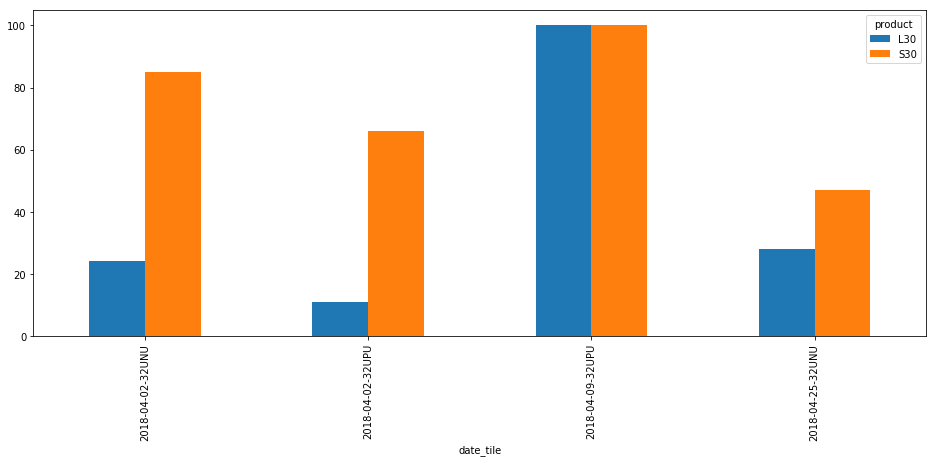

In [7]:
df_downloaded["product_date"] = df_downloaded["product"] + "-" + df_downloaded["date"]
df_downloaded["date_tile"] = df_downloaded["date"] + "-" + df_downloaded["tile"]
#df_downloaded.pivot(index="product_date", columns="tile", values="cloud_cover").plot.bar(figsize=(16, 6))
df_downloaded.pivot(index="date_tile", 
                    columns="product", 
                    values="cloud_cover").plot.bar(figsize=(16, 6))

## Convert HDF to single-layer GeoTIFFs

### Single scene

In [8]:
nasa_hls.convert_hdf2tiffs(Path("./xxx_uncontrolled_hls/downloads/HLS.L30.T32UNU.2018092.v1.4.hdf"), 
                           geotiff_dir,
                           bands=None, # use this to convert only a subset of the bands
                           max_cloud_coverage=100)  # use this to only convert scenes that have lower than specified cloud cover
nasa_hls.convert_hdf2tiffs(Path("./xxx_uncontrolled_hls/downloads/HLS.S30.T32UNU.2018092.v1.4.hdf"), 
                           geotiff_dir,
                           bands=None,
                           max_cloud_coverage=100)

PosixPath('xxx_uncontrolled_hls/geotiffs/HLS.S30.T32UNU.2018092.v1.4')

As a result you get all the (desired) bands in a subfolder of the destination directory.
Note the differences between the L30 and S30 files. 

In [9]:
%%bash
tree xxx_uncontrolled_hls/geotiffs/HLS.L30.T32UNU.2018092.v1.4
tree xxx_uncontrolled_hls/geotiffs/HLS.S30.T32UNU.2018092.v1.4

xxx_uncontrolled_hls/geotiffs/HLS.L30.T32UNU.2018092.v1.4
├── HLS.L30.T32UNU.2018092.v1.4__Blue.tif
├── HLS.L30.T32UNU.2018092.v1.4__Cirrus.tif
├── HLS.L30.T32UNU.2018092.v1.4__Coastal_Aerosol.tif
├── HLS.L30.T32UNU.2018092.v1.4__Green.tif
├── HLS.L30.T32UNU.2018092.v1.4__NIR.tif
├── HLS.L30.T32UNU.2018092.v1.4__QA.tif
├── HLS.L30.T32UNU.2018092.v1.4__QA.tif.aux.xml
├── HLS.L30.T32UNU.2018092.v1.4__Red.tif
├── HLS.L30.T32UNU.2018092.v1.4__SWIR1.tif
├── HLS.L30.T32UNU.2018092.v1.4__SWIR2.tif
├── HLS.L30.T32UNU.2018092.v1.4__TIRS1.tif
└── HLS.L30.T32UNU.2018092.v1.4__TIRS2.tif

0 directories, 12 files
xxx_uncontrolled_hls/geotiffs/HLS.S30.T32UNU.2018092.v1.4
├── HLS.S30.T32UNU.2018092.v1.4__Blue.tif
├── HLS.S30.T32UNU.2018092.v1.4__Cirrus.tif
├── HLS.S30.T32UNU.2018092.v1.4__Coastal_Aerosol.tif
├── HLS.S30.T32UNU.2018092.v1.4__Green.tif
├── HLS.S30.T32UNU.2018092.v1.4__NIR_Broad.tif
├── HLS.S30.T32UNU.2018092.v1.4__NIR_Narrow.tif
├── HLS.S30.T32UNU.2018092.v1.4__QA.tif
├── HLS.S30.T32UNU

### Batch of scene

In [10]:
nasa_hls.convert_hdf2tiffs_batch(df_downloaded[df_downloaded["date"]=="2018-04-02"]["path"].values,
                                 geotiff_dir)

100%|██████████| 4/4 [00:00<00:00, 925.79it/s]


[PosixPath('xxx_uncontrolled_hls/geotiffs/HLS.L30.T32UNU.2018092.v1.4'),
 PosixPath('xxx_uncontrolled_hls/geotiffs/HLS.S30.T32UNU.2018092.v1.4'),
 PosixPath('xxx_uncontrolled_hls/geotiffs/HLS.L30.T32UPU.2018092.v1.4'),
 PosixPath('xxx_uncontrolled_hls/geotiffs/HLS.S30.T32UPU.2018092.v1.4')]

## Create a clear-sky mask from the QA layer

The [HLS v1.4 UserGuide](https://hls.gsfc.nasa.gov/wp-content/uploads/2019/01/HLS.v1.4.UserGuide_draft_ver3.1.pdf) helps to understanding and use the QA layer.

We can read in *Appendix A. How to decode the bit-packed QA*:

*Quality Assessment (QA) encoded at the bit level provides concise presentation but is less convenient for users new to this format.*

This is really true especially if compare the difficulty in handling the QA layer to handling the fmask or sen2cor SCL layer layer. 
Because of that and since the masking of invalid pixels / selection of clear sky pixels is so important we will go in a bit more detail here. 

The rest of this section shows how to create the default mask and custom masks from the bit encoded AQ layer.  

### Sample QA layer

For illustration purposes we use the QA layer of the *HLS.L30.T32UNU.2018092.v1.4* scene.

From the metadata we got the following information about the HDF file:

In [11]:
df_downloaded.loc["HLS.L30.T32UNU.2018092.v1.4", ["cloud_cover", "spatial_coverage"]]

cloud_cover         24
spatial_coverage    29
Name: HLS.L30.T32UNU.2018092.v1.4, dtype: object

### Understand the QA layer

The metadata also gives us a *QA description*. We also find that information in the [HLS v1.4 UserGuide](https://hls.gsfc.nasa.gov/wp-content/uploads/2019/01/HLS.v1.4.UserGuide_draft_ver3.1.pdf):

![title](qa_table.png)

*Appendix A* of the [HLS v1.4 UserGuide](https://hls.gsfc.nasa.gov/wp-content/uploads/2019/01/HLS.v1.4.UserGuide_draft_ver3.1.pdf) *shows how to decode the QA bits with simple integer arithmetic*. 
Here we show a way how to do this in Python.

Lets start with the example from the *Appendix A*:

*Suppose we get a decimal QA value 100, which translates into binary 01100100, indicating that the aerosol level is low (bits 6-7), it is water (bit 5), and adjacent to cloud (bit 2).*

### Derive clear-sky mask from the QA layer

The guide gives some advice on how to use the QA layer:

*Users are advised to mask out Cirrus, Cloud and Adjacent cloud pixels.*

We want to find out here, which rules have been used to calculate the cloud cover we find in in the metadata.
There is no explicit information about the used rules.

Therefore we first create a dataframe where the information of the table above is expanded for easier accessability.
The dataframe can be created with ``get_qa_look_up_table``.

It contains the QA value (i.e. the integer in the raster), the binary string and a boolean column which indicates if for a given QA value a given QA case (i.e. a row in the table above) is met.

In [12]:
lut_qa = nasa_hls.get_qa_look_up_table()
display(lut_qa.head())
display(lut_qa.tail())

,qa_value,binary_string,a_clima,a_low,a_avg,a_high,water,snow,cloud_shadow,adj_cloud,cloud,cirrus,no_water,no_snow,no_cloud_shadow,no_adj_cloud,no_cloud,no_cirrus
0,0,00000000,True,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
1,1,00000001,True,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False
2,2,00000010,True,False,False,False,False,False,False,False,True,False,True,True,True,True,False,True
3,3,00000011,True,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False
4,4,00000100,True,False,False,False,False,False,False,True,False,False,True,True,True,False,True,True


,qa_value,binary_string,a_clima,a_low,a_avg,a_high,water,snow,cloud_shadow,adj_cloud,cloud,cirrus,no_water,no_snow,no_cloud_shadow,no_adj_cloud,no_cloud,no_cirrus
251,251,11111011,False,False,False,True,True,True,True,False,True,True,False,False,False,True,False,False
252,252,11111100,False,False,False,True,True,True,True,True,False,False,False,False,False,False,True,True
253,253,11111101,False,False,False,True,True,True,True,True,False,True,False,False,False,False,True,False
254,254,11111110,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,True
255,255,11111111,False,False,False,True,True,True,True,True,True,True,False,False,False,False,False,False


Based on that dataframe it is easy to get the QA integer values for creating a specific mask from it.

#### Find masking rules resulting in metadata cloud cover

As an example let us see if we can calculate the cloud cover from the QA layer by finding the right QA attributes to be masked.

Let's get the QA values of the sample scene.

In [13]:
qa_path = './xxx_uncontrolled_hls/geotiffs/HLS.L30.T32UNU.2018092.v1.4/HLS.L30.T32UNU.2018092.v1.4__QA.tif'
with rasterio.open(qa_path) as qa:
    meta = qa.meta
    qa_array = qa.read()

Let's first visualize the distribution of the values:

number of observations (not 255) : 3930335


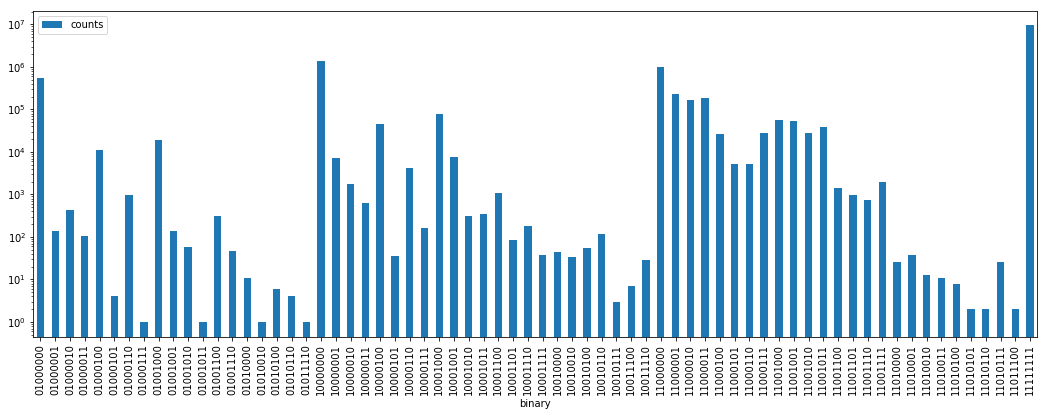

In [14]:
qa_counts = pd.DataFrame(np.unique(qa_array), columns=["integer"])
qa_counts["binary"] = qa_counts.integer.apply(lambda i: "{0:08b}".format(i))
qa_counts["counts"] = qa_counts.integer.apply(lambda i: (qa_array == i).sum())

n_pix = qa_counts["counts"].sum()
n_obs = qa_counts[qa_counts["integer"] != 255].counts.sum()
print("number of observations (not 255) :", n_obs)
qa_counts.plot.bar(x="binary", y="counts", logy=True, figsize=(18, 6))

Let's also calculate the percentage of pixels with respect to all pixels and with respect to the observed pixels (i.e. not 255):

In [15]:
qa_counts["percent"] = ((qa_counts["counts"] / n_pix) * 100).round(2)
qa_counts["percent_obs"] = ((qa_counts["counts"] / n_obs) * 100).round(2)
qa_counts.loc[qa_counts["integer"] == 255, "percent_obs"] = -0.01
qa_counts.tail()

qa_counts_top_22 = qa_counts.sort_values("percent_obs", ascending=False).head(22)
qa_counts_top_22

,integer,binary,counts,percent,percent_obs
19,128,10000000,1389745,10.37,35.36
42,192,11000000,991982,7.41,25.24
0,64,01000000,535713,4.00,13.63
43,193,11000001,228818,1.71,5.82
45,195,11000011,185779,1.39,4.73
44,194,11000010,170090,1.27,4.33
27,136,10001000,79370,0.59,2.02
50,200,11001000,57441,0.43,1.46
51,201,11001001,53104,0.40,1.35
23,132,10000100,44661,0.33,1.14


In [16]:
df_downloaded.loc["HLS.L30.T32UNU.2018092.v1.4", ["cloud_cover", "spatial_coverage"]]

cloud_cover         24
spatial_coverage    29
Name: HLS.L30.T32UNU.2018092.v1.4, dtype: object

**Spatial coverage**

In [17]:
print("spatial coverage from QA: ", 100 - qa_counts.loc[qa_counts["integer"] == 255, "percent"].values[0])

spatial coverage from QA:  29.340000000000003


**Cloud cover**

I could not find in the docs how the AQ layer was used to calculate the cloud cover.

With the percentages in ``qa_counts`` and the ``lut_qa`` dataframe it is now easy to see how different masking decisions influence the percentage of masked pixels for a given QA layer.

The following shows my guesses to find a match for a cloud cover of 24 %.

In [18]:
valid = lut_qa.loc[
        ~((lut_qa.cirrus) | (lut_qa.cloud) | (lut_qa.adj_cloud)), "qa_value"
    ].values
percent_valid = qa_counts.loc[qa_counts.integer.isin(valid), "percent_obs"].sum()
100 - percent_valid

21.810000000000002

In [19]:
valid = lut_qa.loc[
        ~((lut_qa.cloud) | (lut_qa.adj_cloud) | (lut_qa.cloud_shadow)), "qa_value"
    ].values # => 19.8 
percent_valid = qa_counts.loc[qa_counts.integer.isin(valid), "percent_obs"].sum()
100 - percent_valid

19.75999999999999

In [20]:
valid = lut_qa.loc[
        ~((lut_qa.cirrus) | (lut_qa.cloud) | (lut_qa.adj_cloud) | (lut_qa.cloud_shadow)), "qa_value"
    ].values # => 25.8
percent_valid = qa_counts.loc[qa_counts.integer.isin(valid), "percent_obs"].sum()
100 - percent_valid

25.769999999999996

In [21]:
valid = lut_qa.loc[
        ~((lut_qa.cirrus) | (lut_qa.cloud) | (lut_qa.cloud_shadow)), "qa_value"
    ].values # => 23.7
percent_valid = qa_counts.loc[qa_counts.integer.isin(valid), "percent_obs"].sum()
100 - percent_valid

23.67

The winner is: cirrus, cloud and cloud shadow, which somehow makes sense.

That means that we consider the following QA values as clear sky or valid pixels:

In [22]:
valid

array([  0,   4,  16,  20,  32,  36,  48,  52,  64,  68,  80,  84,  96,
       100, 112, 116, 128, 132, 144, 148, 160, 164, 176, 180, 192, 196,
       208, 212, 224, 228, 240, 244])

#### Convert the QA layer into a mask  

Given we know the QA values that we want to consider as valid or invalid pixels we can derive a mask array or GeoTIFF from a GeoTIFF QA layer.

Here we use the function ``hls_qa_layer_to_mask`` to quickly test if the masking with the valid values give us the same cloud cover as the mateadata.

Note that you have the following additional options:

* ``keep_255`` (bool): If ``True`` this keeps the value 255 for the non sensed pixels.
* ``mask_path`` (str): If a path is given the function will create a raster of the mask there and not output an array.
* ``overwrite`` (bool): Defines if a file existing at ``mask_path`` should be overwritten. 


In [23]:
for i, row in df_downloaded.iterrows():
    sceneid = Path(row.path).stem
    qa_path = f'xxx_uncontrolled_hls/geotiffs/{sceneid}/{sceneid}__QA.tif'
    if not Path(qa_path).exists():
        continue
    
    clear_arr = nasa_hls.hls_qa_layer_to_mask(qa_path, 
                                              qa_valid=valid, 
                                              keep_255=True,
                                              mask_path=None, 
                                              overwrite=False)
    n_pix = clear_arr.size
    n_obs = (clear_arr != 255).sum()
    n_cloudy = (clear_arr == 0).sum()
    n_clear = (clear_arr == 1).sum()
    cloud_cover = n_cloudy / (n_clear + n_cloudy)

    print("*" * 90)
    print(qa_path)
    print(f"Number of pixels             : {n_pix}")
    print(f"Number of obs.               : {n_obs}")
    print(f"Number of clear obs.         : {n_clear}")
    print(f"Number of cloudy obs.        : {n_cloudy}")
    
    print(f"Cloud cover - metadata       : {row.cloud_cover}")
    print(f"Cloud cover - calculated     : {round(cloud_cover * 100, 1) }")
    
    print(f"Spatial coverage - metadata  : {row.spatial_coverage}")
    print(f"Spatial coverage - calculated: {round((n_obs / n_pix) * 100, 1) }")

******************************************************************************************
xxx_uncontrolled_hls/geotiffs/HLS.L30.T32UNU.2018092.v1.4/HLS.L30.T32UNU.2018092.v1.4__QA.tif
Number of pixels             : 13395600
Number of obs.               : 3930335
Number of clear obs.         : 2999963
Number of cloudy obs.        : 930372
Cloud cover - metadata       : 24.0
Cloud cover - calculated     : 23.7
Spatial coverage - metadata  : 29.0
Spatial coverage - calculated: 29.3
******************************************************************************************
xxx_uncontrolled_hls/geotiffs/HLS.S30.T32UNU.2018092.v1.4/HLS.S30.T32UNU.2018092.v1.4__QA.tif
Number of pixels             : 13395600
Number of obs.               : 13272703
Number of clear obs.         : 1976262
Number of cloudy obs.        : 11296441
Cloud cover - metadata       : 85.0
Cloud cover - calculated     : 85.1
Spatial coverage - metadata  : 100.0
Spatial coverage - calculated: 99.1
**************************

**!!! NOTE AND WARNING !!!**

**There are some small irregularities between the metadata and the calculated values that should be investigated further.**

**Feel free to do so... (;**

#### Visualize the mask

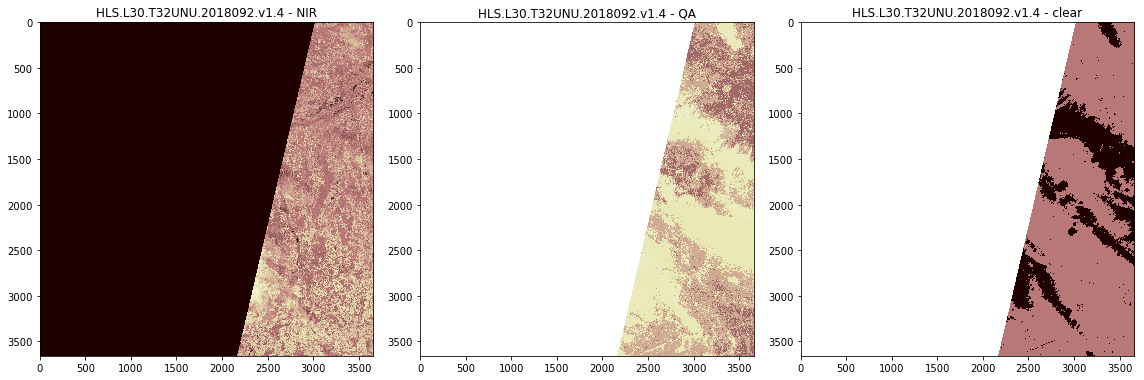

In [24]:
sceneid = "HLS.L30.T32UNU.2018092.v1.4"
src_nir = rasterio.open(f'xxx_uncontrolled_hls/geotiffs/{sceneid}/{sceneid}__NIR.tif')
src_qa = rasterio.open(f'xxx_uncontrolled_hls/geotiffs/{sceneid}/{sceneid}__QA.tif')
qa_path = f'xxx_uncontrolled_hls/geotiffs/{sceneid}/{sceneid}__QA.tif'

clear_arr = nasa_hls.hls_qa_layer_to_mask(qa_path, 
                                          qa_valid=valid, 
                                          keep_255=True,
                                          mask_path=None, 
                                          overwrite=False)

fig, axes = plt.subplots(1, 3, figsize=(16, 8))

axes[0].imshow(src_nir.read(1), vmin=0, vmax=6000, cmap='pink')
axes[0].set_title(sceneid + " - " + "NIR")
axes[1].imshow(src_qa.read(1), vmin=0, vmax=255, cmap='pink')
axes[1].set_title(sceneid + " - " + "QA")
axes[2].imshow(clear_arr, vmin=0, vmax=3, cmap='pink')
axes[2].set_title(sceneid + " - " + "clear")
fig.tight_layout()